# MODELO USANDO RED NEURONAL

In [16]:
import tensorflow as tf
from scipy.stats import boxcox
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, SimpleRNN, Flatten, BatchNormalization
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from keras.regularizers import l1, l2
import scipy.stats as ss# ss sirve para hacer la transformación de box-cox
import scipy.stats as st

Num GPUs Available:  1


In [32]:
df_dl=pd.read_csv('data.csv')
df_dl

,ID,PAY,ACCEPTED
0,786,27.352507,0
1,868,51.939040,1
2,846,24.451818,1
3,249,29.353959,1
4,434,20.568923,1
...,...,...,...
1295,579,25.306900,0
1296,871,36.827302,1
1297,209,20.824530,0
1298,165,26.291693,1


In [33]:
df_dl["ACCEPTED"].value_counts()

1    827
0    473
Name: ACCEPTED, dtype: int64

In [34]:
df_dl.isna().sum()

ID          0
PAY         0
ACCEPTED    0
dtype: int64

In [5]:
df_dl.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,1300.0,497.563846,289.749383,1.0,249.000000,494.000000,744.000000,1000.000000
PAY,1300.0,26.626490,9.363111,0.0,20.801887,26.749334,33.348092,53.667563
ACCEPTED,1300.0,0.636154,0.481290,0.0,0.000000,1.000000,1.000000,1.000000


In [35]:
#conmsideramos puy a cero 
df_dl[df_dl["PAY"]==0].value_counts()

ID   PAY  ACCEPTED
63   0.0  0           1
177  0.0  0           1
478  0.0  0           1
701  0.0  0           1
781  0.0  0           1
987  0.0  0           1
dtype: int64

In [36]:
df_renew=df_dl[df_dl['PAY'] > 0] # consideramos solo los valores mayores a cero


In [37]:
df_renew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1294 entries, 0 to 1299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        1294 non-null   int64  
 1   PAY       1294 non-null   float64
 2   ACCEPTED  1294 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 40.4 KB


In [38]:
#agrupamos por ID para ver cuantos pagos se han hecho y cuantos se han aceptado
df_guay = df_renew.groupby('ID')[['PAY', 'ACCEPTED']].sum()

In [39]:
df_guay

,PAY,ACCEPTED
ID,,
1,29.358732,0
2,22.986847,0
3,18.020348,0
4,77.749694,2
5,14.642845,0
...,...,...
996,17.382310,0
997,20.855120,0
998,42.122166,1


C:\Users\victo\AppData\Local\Temp\ipykernel_16708\230468569.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ganancias, color='green', label='aceptadas')
C:\Users\victo\AppData\Local\Temp\ipykernel_16708\230468569.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(perdidas, color='red', labe

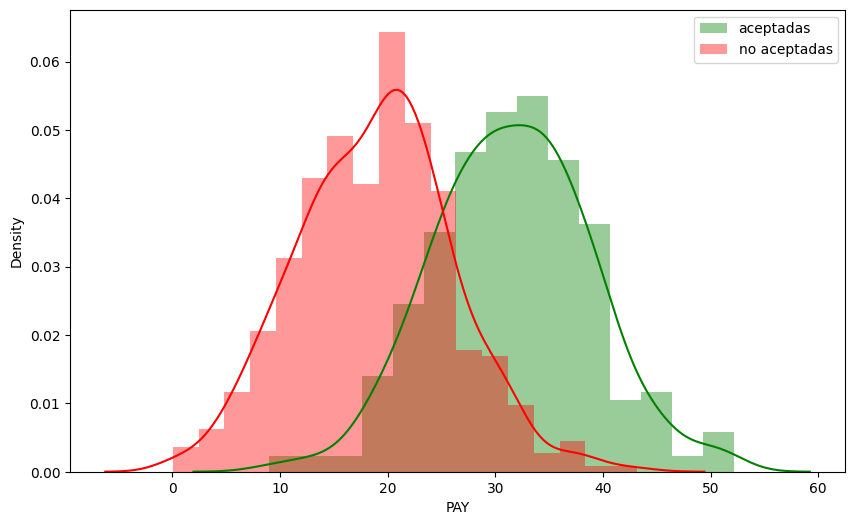

In [40]:
#visionamos  las aceptadas y no aceptadas del negocio
ganancias=df_guay.loc[df_guay['ACCEPTED'] == 1, 'PAY']#clientes q usan el servicio
perdidas=df_guay.loc[df_guay['ACCEPTED'] == 0, 'PAY']#clientes que no usan el servicio
plt.figure(figsize=(10,6))
sns.distplot(ganancias, color='green', label='aceptadas')
sns.distplot(perdidas, color='red', label='no aceptadas')
plt.legend();

las pagos aceptados y no acpetados siguen una distribucición gaussiana, siendo las lineas muy similares

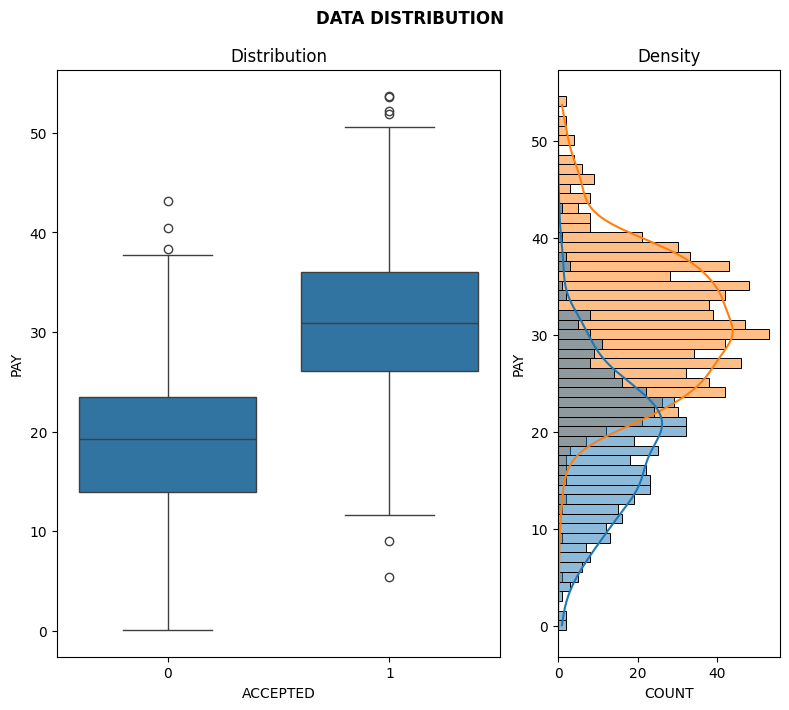

In [41]:
#visionamos la distribucion de los datos
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1.5]}, figsize=(8,7))
fig.suptitle('DATA DISTRIBUTION\n', fontweight='bold')
fig.tight_layout()

sns.boxplot(ax=ax[0], data=df_renew, x='ACCEPTED', y='PAY')
ax[0].set_title('Distribution')

sns.histplot(ax=ax[1], data=df_renew, y='PAY', hue='ACCEPTED', kde=True, discrete=True)
ax[1].set_title('Density')
ax[1].legend_.remove()
ax[1].set_xlabel('COUNT')

plt.show()

POSSION

In [42]:
def visualizar_distribucion_poisson(eventos_maximos: int, tasa_promedio: float):
    """
    Visualiza la función de masa de probabilidad (PMF) y la función de distribución acumulada (CDF) 
    de una distribución de Poisson.

    Args:
        eventos_maximos (int): Número máximo de eventos a considerar.
        tasa_promedio (float): Tasa promedio de ocurrencia de eventos (lambda).
    """
    
    # Rango de eventos (0 hasta eventos_maximos)
    eventos = np.arange(eventos_maximos + 1)

    # Calcular la PMF y la CDF
    pmf = st.poisson.pmf(eventos, tasa_promedio)
    cdf = st.poisson.cdf(eventos, tasa_promedio)

    # Crear la gráfica
    plt.figure(figsize=(10, 6))  # Ajustar el tamaño de la figura (opcional)
    plt.plot(eventos, pmf, marker='o', linestyle='-', color='blue', label='PMF')
    plt.plot(eventos, cdf, marker='x', linestyle='--', color='red', label='CDF')
    plt.xlabel('Número de Eventos (k)')
    plt.ylabel('Probabilidad')
    plt.title('Distribución de Poisson (λ = {:.2f})'.format(tasa_promedio))
    plt.legend()
    plt.grid(axis='y', alpha=0.5)  # Agregar una cuadrícula (opcional)
    plt.show()


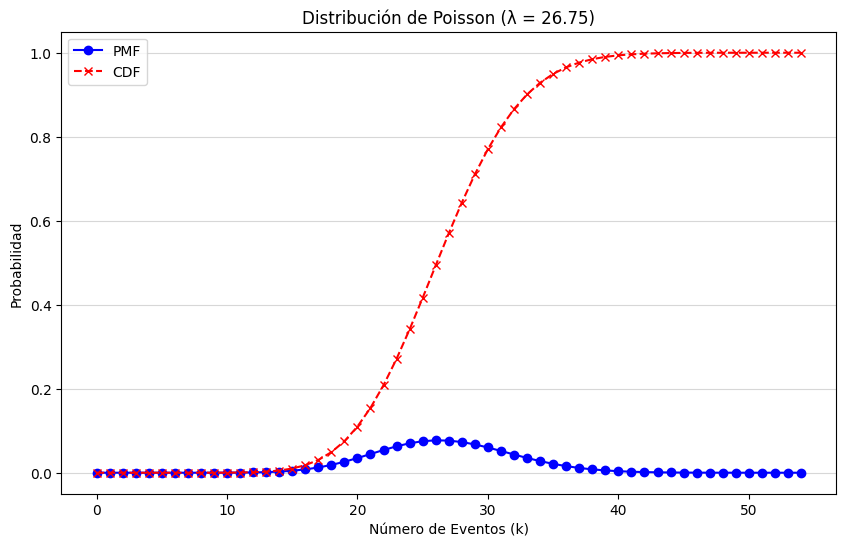

In [19]:
eventos_maximos = df_renew['PAY'].max()
tasa_promedio = df_renew['PAY'].mean()
visualizar_distribucion_poisson(eventos_maximos, tasa_promedio)

EN la grafica observamos que la linea azul marca un maximod e viajes de unos 27 como valor maximo, con una probailidad que se de esa cifra de 0.1 aproximadamente. SI nos fijamos en la liena roja que son la probabilidad que ocurran un determinado nuemro de viajes, es ascendente a partir de 17 aprox. Si hacemos una comparacion entrela la masa real y la acumulada, podemos observar que si nos fijamos en el valor 30, para la linea azul la probabilidad que se produzca es bajísima , sin embargo en la acumulada es de casi un 0.80, por lo que esta diferencia indica, que seguramente se den mas evenetos que los que ha marcado la linea azul como maximo, es decir mas de 27 hasta un maxcximo de 40.

In [43]:
# pago medio a conductores
pago_medio = df_renew['PAY'].mean()
pago_medio

26.74995159716842

In [116]:
#numero de viajes totales
viajes_totales = df_renew['PAY'].count()
viajes_totales


26.74995159716842

In [45]:
def ganancias_mensuales(pago_medio, numero_viajes):
    """
    Calcula las ganancias totales del servicio en 12 meses.

    Args:
        pagos_conductores (list): Lista de pagos a conductores por viaje.
        numero_viajes (int): Número de viajes completados.

    Returns:
        float: Ganancias totales.
    """
  
    ingresos = numero_viajes * 30  # Tasa de pago anual de 30 euros
    costos = np.sum(pago_medio) * numero_viajes  # Costos por viaje
    return (ingresos - costos)/12   

In [46]:
Ganancias_mensuales=ganancias_mensuales(pago_medio,viajes_totales)
print(f"el total de gananacias mensuales es :{Ganancias_mensuales}$")
Ganancias_anuales=Ganancias_mensuales*12
print(f"el total de gananacias anuales es :{Ganancias_anuales}$")

el total de gananacias mensuales es :350.46355277200564$
el total de gananacias anuales es :4205.562633264068$


# primer modelo 

In [50]:
#  la columna que contiene la serie temporal los ingresos dentro de 12 meses y con acpetados masyores que 0
df = df_renew[['PAY']]

#escalo datos para que esten entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

In [51]:
#al ser una serie temporal, el resultado debe ser 3 valores [muestras, pasos de tiempo, características], por que usarmeos la tecnica del DESFASE usando shift
# creando un desfase de 12 meses
desfase = 12#numero de meses
df = pd.DataFrame(df)#creo un dataframe vacio
for i in range(1, desfase+1):
    df['desfase_' + str(i)] = df[0].shift(i)#las nuevas columnas se llamaran desfase_1,2,3,4...... donde desplazaran los datos
                                           


In [52]:
df.isna().sum()#estos nulos se han ido acumulando durante el proceso de despalzamiento del desfase por lo que los anulamos

0              0
desfase_1      1
desfase_2      2
desfase_3      3
desfase_4      4
desfase_5      5
desfase_6      6
desfase_7      7
desfase_8      8
desfase_9      9
desfase_10    10
desfase_11    11
desfase_12    12
dtype: int64

In [53]:

# Elimina las filas con NaN 
df = df.dropna()

In [54]:
# Convierte el DataFrame a un array de numpy
data = df.values
data = data.astype('float32')

In [56]:
# Creamos X e y con el paso de tiempo en 1
def create_dataset(df, desfase=1):
    X, y = [], []
    for i in range(len(df)-desfase-1):
        V = df[i:(i+desfase), 0]
        X.append(V)
        y.append(df[i + desfase, 0])
    return np.array(X), np.array(y)

In [57]:
# Crea X e y
X, y = create_dataset(data, desfase)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1015, 12), (1015,), (254, 12), (254,))

In [78]:
# Redimensiona los datos para que tengan los dotos para una serie temporal simulando p, q, d [muestras, pasos de tiempo, características]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[2], 1 ))

print(X_train.shape, X_test.shape)

(1015, 12, 1) (254, 12, 1)


In [79]:
model = Sequential()

# Capa Bidireccional con LSTM
model.add(Bidirectional(LSTM(1024, return_sequences=True), input_shape=(12,1)))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.2))

# Capa GRU
model.add(GRU(1024, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(BatchNormalization())

# Capa SimpleRNN
model.add(SimpleRNN(1024, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Capa LSTM
model.add(Bidirectional(LSTM(2024, return_sequences=True)))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))                  
model.add(Dropout(0.2))     

# Capa Flatten
model.add(Flatten())

# Capa Dense
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 12, 2048)         8404992   
 l)                                                              
                                                                 
 dense (Dense)               (None, 12, 1024)          2098176   
                                                                 
 dropout (Dropout)           (None, 12, 1024)          0         
                                                                 
 gru (GRU)                   (None, 12, 1024)          6297600   
                                                                 
 dropout_1 (Dropout)         (None, 12, 1024)          0         
                                                                 
 dense_1 (Dense)             (None, 12, 1024)          1049600   
                                                        

In [80]:
optimizador=tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    name='Adam',
    clipnorm=1,
    clipvalue=0.3  
    )
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, min_lr=0.0001)
list=[early_stopping,reduce_lr]

model.compile(loss='mean_squared_error', optimizer=optimizador, metrics=['mean_squared_error'])
historia=model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, callbacks=list)

Epoch 1/100
32/32 [==============================] - 16s 105ms/step - loss: 37.9423 - mean_squared_error: 0.1505 - lr: 1.0000e-04
Epoch 2/100
32/32 [==============================] - 3s 106ms/step - loss: 30.5222 - mean_squared_error: 0.0347 - lr: 1.0000e-04
Epoch 3/100
32/32 [==============================] - 3s 107ms/step - loss: 24.2202 - mean_squared_error: 0.0331 - lr: 1.0000e-04
Epoch 4/100
32/32 [==============================] - 3s 107ms/step - loss: 19.1151 - mean_squared_error: 0.0326 - lr: 1.0000e-04
Epoch 5/100
32/32 [==============================] - 3s 109ms/step - loss: 15.0249 - mean_squared_error: 0.0327 - lr: 1.0000e-04
Epoch 6/100
32/32 [==============================] - 3s 109ms/step - loss: 11.7680 - mean_squared_error: 0.0313 - lr: 1.0000e-04
Epoch 7/100
32/32 [==============================] - 3s 108ms/step - loss: 9.1902 - mean_squared_error: 0.0318 - lr: 1.0000e-04
Epoch 8/100
32/32 [==============================] - 3s 109ms/step - loss: 7.1569 - mean_squared_

<Axes: >

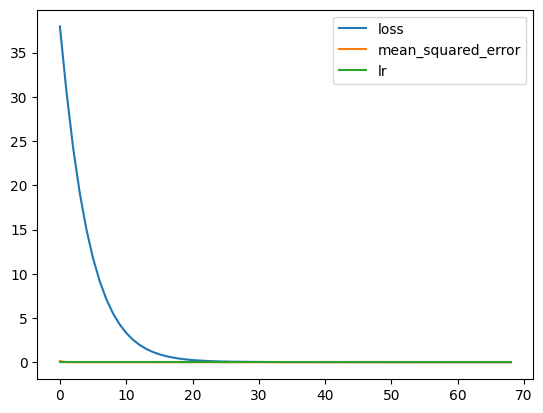

In [81]:
historia=pd.DataFrame(historia.history)
historia[["loss", "mean_squared_error", "lr"]].plot()


In [82]:
# Hacer predicciones
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

8/8 [==============================] - 0s 29ms/step


In [83]:
y_test.shape, testPredict.shape,X_test.shape, y_train.shape, trainPredict.shape, X_train.shape

((254,), (254, 1), (254, 12, 1), (1015,), (1015, 1), (1015, 12, 1))

In [85]:
# Redimensiona X_test a 2 dimensiones para que pueda hacer la transformación inversa
X_test_2d = X_test.reshape((X_test.shape[0], X_test.shape[1]))#redimensiono a nuemer de muestras y numero de caracteristicas


In [86]:
X_test_2d.shape

(254, 12)

In [87]:
#TEST_invereti los datos para que tengan sentido y sean reales y compararlos con los datos originales
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(X_test_2d)


In [88]:
# Redimensiona X_train a 2 dimensiones para que pueda hacer la transformación inversa
X_train_2d = X_train.reshape((X_train.shape[0], X_train.shape[1]))#redimensiono a numeros de muestras y caracteristicas

In [89]:
#TRAIN_invertimos la escala de los datos para obtener los valores reales y tenga sentido
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(X_train_2d)

In [97]:
# Calcular el error cuadrático medio
trainScore = np.sqrt(mean_squared_error(y_train[:,0], trainPredict[:,0]))#calculamos el RMSE entre las etiquetas verdaderas y 
                                                                        #las que se han predicho,  para cuantificar la diferencia
                                                                            # de valores de la serie temporal
print(f'Train RMSE:{round(trainScore,2)}')

testScore = np.sqrt(mean_squared_error(y_test[:,0], testPredict[:,0]))
print(f'Test RMSE:{round(testScore,2)}')


Train RMSE:9.180000305175781
Test RMSE:9.65999984741211


In [99]:
# Calcular el meab absolute error percentage y el r2
mape = mean_absolute_percentage_error(y_test[:,0], testPredict[:,0])
print('MAPE: %.2f' % (mape))



MAPE: 0.39


RESUMEN

In [126]:
df_testPredict = pd.DataFrame(testPredict, columns=['Predictions'])
df_test = pd.DataFrame(y_test[:, 0], columns=['True'])


In [127]:
df_testPredict

,Predictions
0,25.344473
1,25.344309
2,25.340378
3,25.340376
4,25.341782
...,...
249,25.341301
250,25.341024
251,25.341444
252,25.336535


In [128]:
df_test

,True
0,20.485388
1,15.943325
2,16.033068
3,29.740749
4,17.613016
...,...
249,32.802265
250,10.870018
251,17.675997
252,39.118046


In [131]:
ganancias_predichas= Ganancias_anuales+df_testPredict["Predictions"].sum()
Ganancias_reales= Ganancias_anuales+df_test["True"].sum()
print(f"las ganancias anuales predichas  son:{round(ganancias_predichas,2)}$")
print(f"las ganancias anueles reales son:{round(Ganancias_reales,2)}$")


las ganancias anuales predichas  son:10641.89$
las ganancias anueles reales son:11091.17$


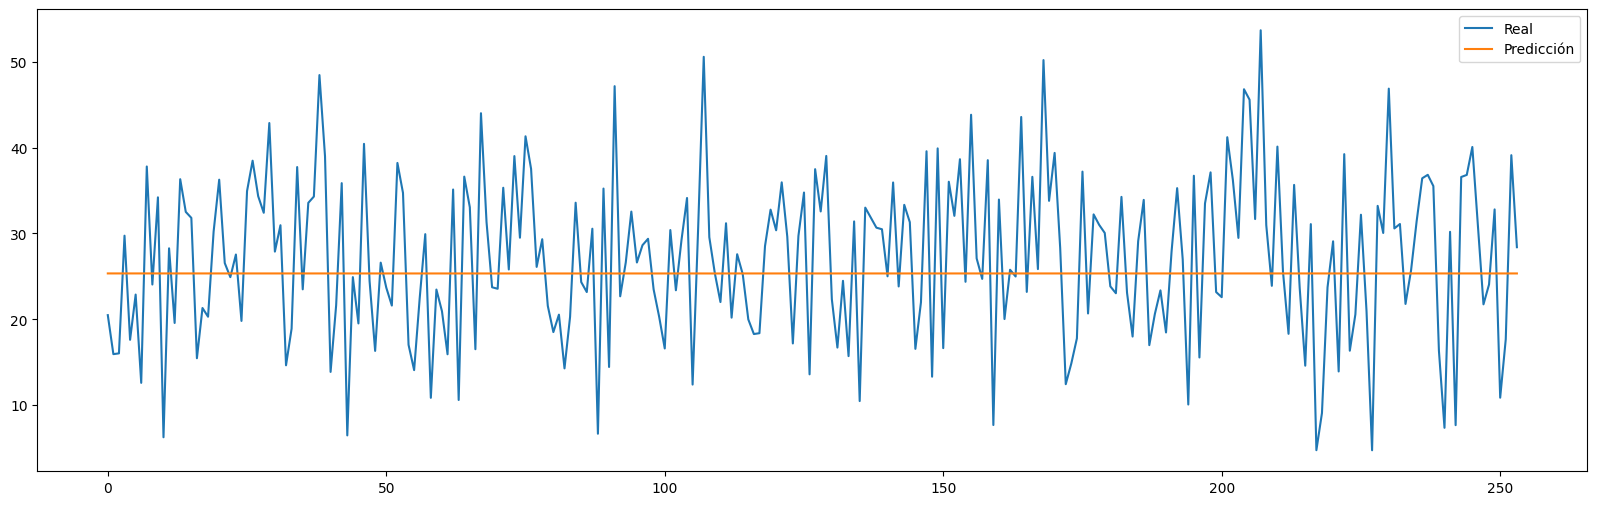

In [114]:
#graficas que podemos hacer con la serie temporal
plt.figure(figsize=(20,6))
plt.plot(y_test[:,0], label='Real')
plt.plot(testPredict[:,0], label='Predicción')
plt.legend()
plt.show()


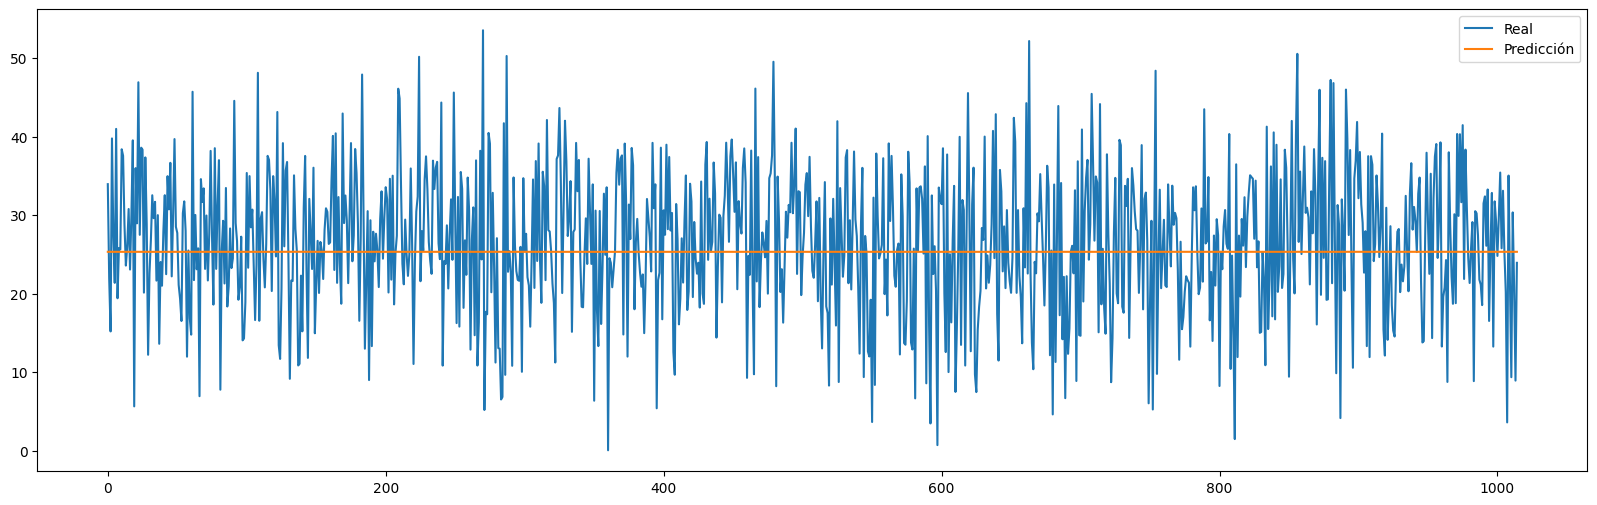

In [115]:
plt.figure(figsize=(20,6))
plt.plot(y_train[:,0], label='Real')
plt.plot(trainPredict[:,0], label='Predicción')
plt.legend()
plt.show()


